In [1]:
import torch
from torch import nn
from torchvision import transforms, datasets, io
from torch.utils.data import DataLoader
import os
from os.path import join
from PIL import Image #image reader
import numpy as np
from typing import Any, Callable, cast, Dict, List, Optional, Tuple

import torchvision.transforms.functional as TF
import albumentations as A
import sys
sys.path.append(os.path.join(os.getcwd(),'..'))

from utils.utils_imloader import ImLoader
from utils.utils_unet import UNet
from utils.utils_modules import *
from utils.utils_training import BaseUNetTraining
from utils.utils_dataset import UnetDataset

In [2]:
os.getcwd()

'/afs/crc.nd.edu/user/j/jlee88/Unet-Research/Unet_research/unet_code/base_model_tests'

In [3]:
root = '../../'

In [4]:
os.listdir(root)

['results',
 'augmented_data',
 'README.txt',
 'Makefile',
 'create_augmentations.o21028',
 'training.o23248',
 'training.o23250',
 'training.o23251',
 'datasets',
 'training.o23252',
 'training.o23256',
 'training.o23257',
 'training.o23253',
 'unet_code',
 'training.o24166',
 'training.o24167',
 'training.o24168',
 'training.o24172',
 'requirements.sh',
 'training.o23246',
 'training.o23247']

In [5]:
train_root = root + 'augmented_data/train/'
val_root = root + 'augmented_data/val/'
test_root = root + 'augmented_data/test/'

add_images = lambda x: join(x, 'images')
add_targets = lambda x: join(x, 'targets')
add_masks = lambda x: join(x, 'masks')

# datasets
train_dataset = UnetDataset(image_root=add_images(train_root),
                                target_root=add_targets(train_root),
                                mask_root=add_masks(train_root),
                                mode = {'image': 'L', 'target': 'L', 'mask' : 'L'})
val_dataset = UnetDataset(image_root=add_images(val_root),
                                target_root=add_targets(val_root),
                                mask_root=add_masks(val_root),
                                mode = {'image': 'L', 'target': 'L', 'mask' : 'L'})
test_dataset = UnetDataset(image_root=add_images(test_root),
                            mask_root = add_masks(test_root),
                                mode = {'image': 'L', 'target': 'L', 'mask' : 'L'})

train_batch_size = 1
val_batch_size = 1
test_batch_size = 1

# load into dataloaders
train_loader = DataLoader(train_dataset, batch_size = train_batch_size,shuffle=True, drop_last=False, num_workers=2) 
val_loader = DataLoader(val_dataset, batch_size = val_batch_size, shuffle = False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle = False, num_workers=2)

In [6]:
DataLoader(test_loader.dataset, 1, shuffle = False)

In [7]:
image, gt, mask = train_dataset[0]

In [8]:
gt.max()

tensor(1.)

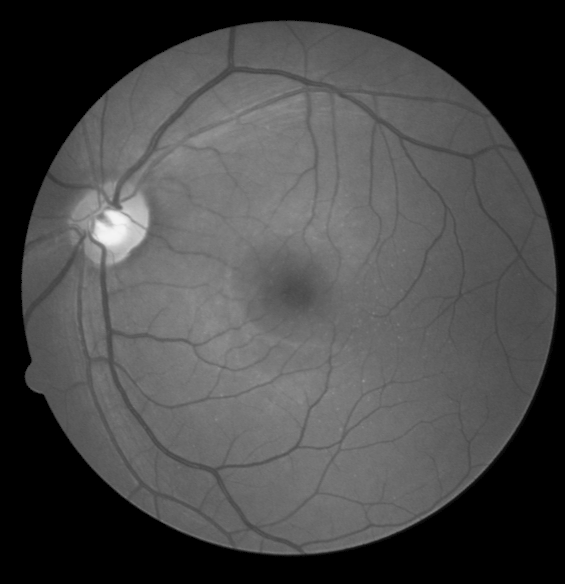

In [9]:
transforms.ToPILImage(mode = 'L')(image * mask)

In [10]:
unet = UNet(init_channels=1,
                filters=64,
                output_channels=1,
                model_depth=4,
                pool_mode='max',
                up_mode='upconv',
                connection='cat',
                same_padding=True,
                conv_layers_per_block=2,
                checkpointing=True
                )

In [11]:
unet.set_activation_function(nn.ReLU())
unet.set_dropblock(Dropblock2d_ichan, 7, .1, True, 0, .25, dropblock_ls_steps = 500)
unet.set_normalization(nn.BatchNorm2d, params = {'num_features':"fill"})
unet.create_model()

In [12]:
# loss function
loss_fn = nn.BCELoss()

# optimizer
optimizer = torch.optim.SGD(params = unet.parameters(), lr = .001,momentum = .99 )

model = BaseUNetTraining(unet, loss_fcn=loss_fn, optimizer = optimizer )


In [13]:
import pytorch_lightning as pl


In [14]:
trainer = pl.Trainer(logger = False, fast_dev_run=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).


trainer.fit(model,train_loader,val_loader)

In [15]:
data = trainer.predict(model, dataloaders = [val_loader] )

/afs/crc.nd.edu/user/j/jlee88/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

/afs/crc.nd.edu/user/j/jlee88/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Predicting: 100%|██████████| 1/1 [00:17<00:00, 17.98s/it]


In [16]:
id, seg, im, gt = data[0]

trainer.logged_metrics['val_loss_avg']

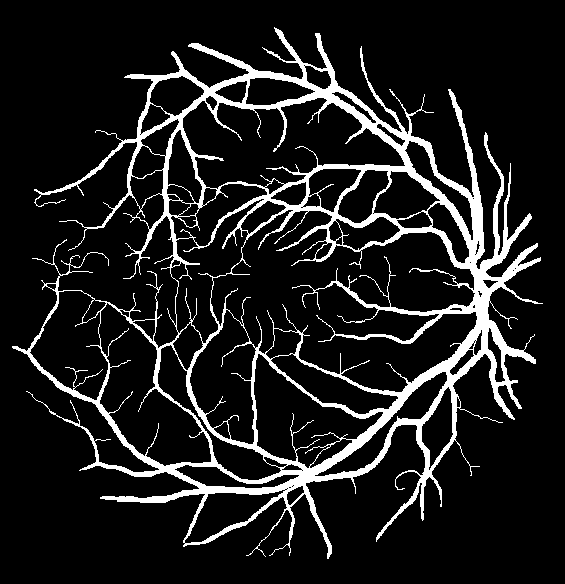

In [17]:
transforms.ToPILImage(mode = 'L')(gt[0])

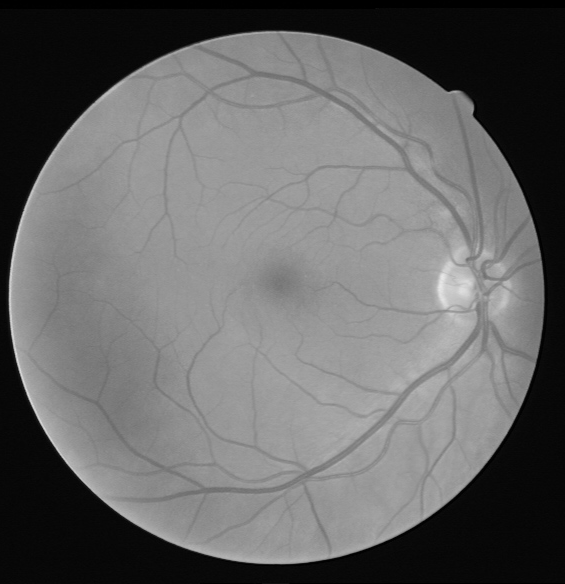

In [18]:
transforms.ToPILImage(mode = 'L')(im[0])

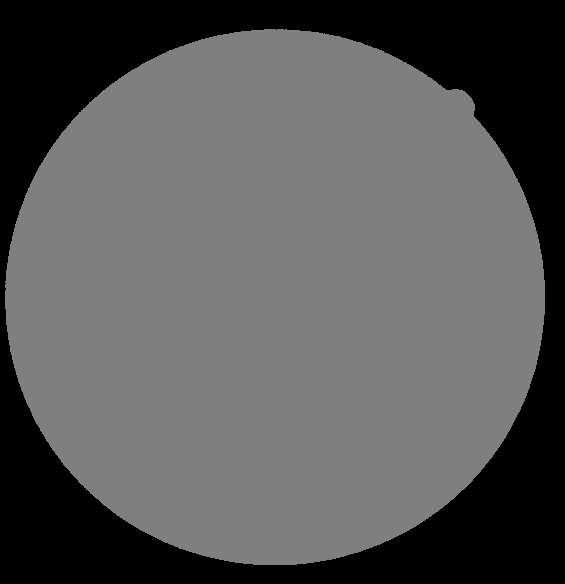

In [19]:
transforms.ToPILImage(mode = 'L')(seg[0])

In [20]:
from utils.utils_metrics import *

In [21]:
get_accuracy_metrics(seg[0], gt[0])

(0.2880510161008261, 0.6760723626244041, 0.427506364407807)

In [22]:
final_test_metrics(trainer,model,val_loader,test_loader, save_path = 'test')

/afs/crc.nd.edu/user/j/jlee88/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Saved Losses
Predicting: 100%|██████████| 1/1 [00:16<00:00, 16.40s/it]
Saved Test Data
Predicting: 100%|██████████| 1/1 [00:16<00:00, 16.01s/it]
Saved Val Data
Saved All Metrics
